## <center> XGBoost model. Tuning and creating submission

In [1]:
%store -r X_train
%store -r X_test

%store -r y_train
%store -r y_test

%store -r X_train_sub
%store -r X_test_sub
%store -r y_train_sub
%store -r y_test_sub

no stored variable y_test


### Import libraries

In [ ]:
send_submission = False

In [ ]:
_da

In [ ]:
import sys
import os
sys.pa### Import libraries

send_submission = False

_dath.append(os.path.realpath('./../../scripts'))

In [4]:
import numpy as np
import pandas as pd 

import xgboost as xgb
from xgboost import plot_importance

import warnings
import matplotlib.pyplot as plt
%matplotlib inline 


from IPython.core.debugger import set_trace
from time import time

# SKLEARN

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, KFold
from sklearn.metrics import r2_score

# Bayessian Optimization
from bayes_opt import BayesianOptimization
from hyperopt import hp
from hyperopt import fmin, tpe, space_eval
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# vecstack
from vecstack import stacking

In [ ]:
def get_xgb(params = {}):
    return XGBReggresor(
           boosting_type= 'gbdt',
           objective = 'reg:squarederror',
           metric = "rmse",
           random_state= 1,
           silent = True,
           **params)

def create_submission(model, submission_name, send_submission=False, message="XGBoost"):
    result = model.predict(X_test_sub)
    submission = pd.DataFrame({
        "ID": np.arange(result.shape[0]), 
        "item_cnt_month": result
    })
    submission.to_csv(submission_name, index=False)
   
    if send_submission:
        !kaggle competitions submit -c competitive-data-science-predict-future-sales -f {submission_name} -m {message}

In [ ]:
%%notify -m "Grid search XGBoost was ended"

gridParams = {
    'learning_rate': np.linspace(0.01, 2, 10),
    'max_depth': np.arange(0, 14),
    'n_estimators': np.arange(100, 1000, 100),
    'num_leaves': np.arange(8, 65, 8),
    'colsample_bytree' : [0.65, 0.66],
    'subsample' : np.arange(0.5, 1.1, 0.1),
    'reg_alpha' : np.arange(0, 100),
    'reg_lambda' : np.arange(0, 100)
}

xgb_model = get_xgb()

# Create the grid
grid = RandomizedSearchCV(xgb_model, gridParams, verbose=0, cv=TimeSeriesSplit(n_splits=5))

grid.fit(X_train, y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=10, 
    early_stopping_rounds=20)

In [ ]:
print("Score", grid.best_score_)
print('Fitting with params: ')
print(grid.best_params_)

In [ ]:
rmse =  np.sqrt(mean_squared_error(y_test, grid.best_estimator.predict(X_test))) 
print(f"RMSE {rmse}")

Tuned parameters from RandomizedSearch.

In [53]:
params = {'subsample': 0.89,
 'reg_lambda': 11,
 'reg_alpha': 32,
 'num_leaves': 40,
 'n_estimators': 400,
 'max_depth': 7,
 'learning_rate': 0.45222222222222225,
 'colsample_bytree': 0.66}

In [ ]:
%%notify -m "XGBoost submission have been fit"

lgbm = get_xgb(params)
lgbm.fit(X_train_sub, y_train_sub, 
    eval_metric="rmse", 
    eval_set=[(X_train_sub, y_train_sub)], 
    verbose=0, 
    early_stopping_rounds=20,
    categorical_feature = cat_feats)    

In [57]:
%%notify -m "Submission was created"
create_submission(lgbm, 'xgb_submission_gs.csv', make_submission)

<IPython.core.display.Javascript object>

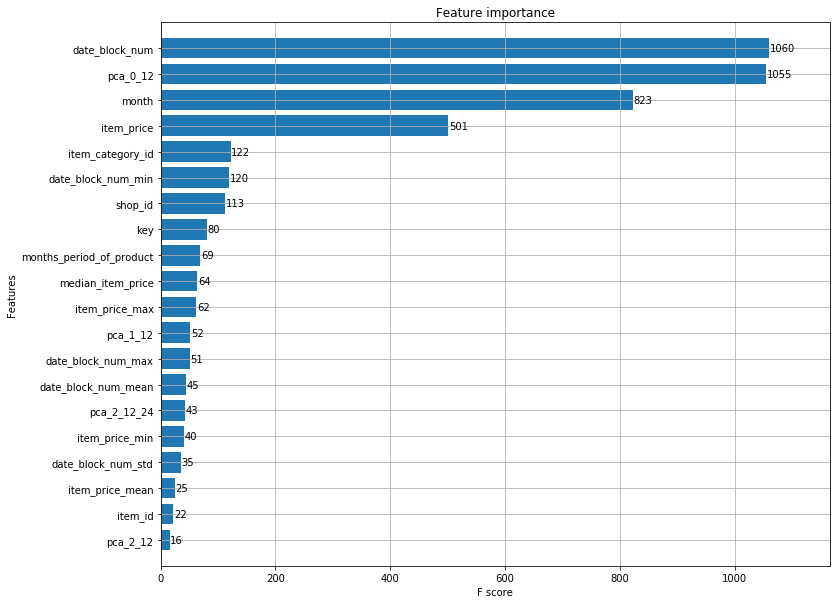

In [39]:
fig, ax = plt.subplots(figsize=(12,10))
xgb.plot_importance(gbm_model, max_num_features=20, height=0.8, ax=ax)
plt.show()

In [65]:
len(progress['eval']['rmse'])

300

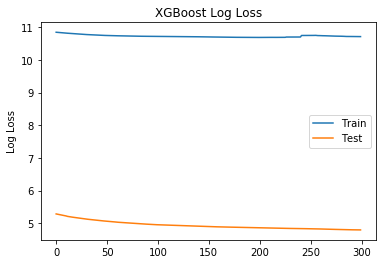

In [67]:
# make predictions for test data
y_pred = gbm_model.predict(dvalid)
predictions = np.round(y_pred)
# evaluate predictions
accuracy = mape(y_test, predictions)
# retrieve performance metrics
epochs = len(progress['eval']['rmse'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, progress['eval']['rmse'], label='Train')
ax.plot(x_axis, progress['train']['rmse'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()